# Importing all required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import folium
from datetime import datetime

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
pd.__version__

'1.1.5'

In [3]:
df=pd.read_excel('time-series-data.xlsx')

# Data cleaning and preprocessing

In [4]:
df=df.sort_values(by='Date', ascending=True)
df.head()


,Country,Localite,Category,Value,Date
46857,Guinea,National,Suspected Cases,9,1900-01-04
46887,Guinea,National,Probable cases,337,1900-01-04
46977,Guinea,National,Deaths,1926,1900-01-04
0,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Cases,86,2014-03-24
1,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Deaths,59,2014-03-24


In [5]:
df=df[df.Date !='1900-01-04' ]   # Removing 1900-01-04 which is wrong.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58632 entries, 0 to 58634
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Country   58632 non-null  object        
 1   Localite  58632 non-null  object        
 2   Category  58632 non-null  object        
 3   Value     58214 non-null  object        
 4   Date      58632 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.7+ MB


In [7]:
df.shape

(58632, 5)

In [8]:
df['Value']=pd.to_numeric(df['Value'],errors='coerce')

In [9]:
df.isna().sum()

Country       0
Localite      0
Category      0
Value       425
Date          0
dtype: int64

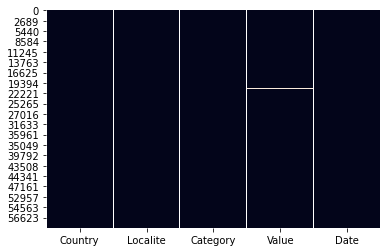

In [10]:
sns.heatmap(df.isnull(), cbar=False)

In [11]:
df=df.dropna(subset=['Value'])

In [12]:
df.shape

(58207, 5)

In [13]:
df['Value'].dtypes

dtype('float64')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58207 entries, 0 to 58634
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Country   58207 non-null  object        
 1   Localite  58207 non-null  object        
 2   Category  58207 non-null  object        
 3   Value     58207 non-null  float64       
 4   Date      58207 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.7+ MB


In [15]:
# df['Year']=df.Date.dt.year
# df['Month_name']=df.Date.dt.month_name()
# df['Day_name']=df.Date.dt.day_name()
# df['Month']=df.Date.dt.month
# df['Week']=df.Date.dt.week
# df['Day_of_year']= df.Date.dt.dayofyear



In [16]:
df.Category.unique()

array(['Cases', 'Deaths', 'Suspected cases', 'Confirmed cases',
       'Probable cases', 'New cases', 'Suspected Cases', 'New Cases'],
      dtype=object)

In [17]:
di={'Suspected cases':'Suspected Cases','New cases':'New Cases'}
df=df.replace({"Category":di})

In [18]:
df1=df[df.Localite != 'National']

In [19]:
df_1= pd.pivot_table(df1,values='Value',columns='Category',index=['Date','Country','Localite'],fill_value=0).reset_index()

In [20]:
df_1['Recovered']=(df_1['Cases']-df_1['Deaths']).abs()

In [21]:
df_1.tail(5)


Category,Date,Country,Localite,Cases,Confirmed cases,Deaths,New Cases,Probable cases,Suspected Cases,Recovered
9476,2015-03-28,Sierra Leone,Port,1923.0,1440.0,624.0,0.0,2.0,481.0,1299.0
9477,2015-03-28,Sierra Leone,Pujehun,63.0,31.0,21.0,0.0,2.0,30.0,42.0
9478,2015-03-28,Sierra Leone,Tonkolili,571.0,454.0,185.0,0.0,25.0,92.0,386.0
9479,2015-03-28,Sierra Leone,Western area rural,1545.0,1163.0,520.0,0.0,2.0,380.0,1025.0
9480,2015-03-28,Sierra Leone,Western area urban,3034.0,2224.0,763.0,2.0,5.0,805.0,2271.0


In [22]:
df_1.groupby('Country')['Cases','Deaths','Recovered'].sum()


C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Category,Cases,Deaths,Recovered
Country,,,
Guinea,363349.5,230414.0,133299.5
Liberia,843783.0,375444.0,471723.0
Mali,52.0,42.0,10.0
Nigeria,460.0,168.0,292.0
Senegal,19.0,0.0,19.0
Sierra Leone,1367120.0,424962.0,948612.0


In [23]:
print('The data is from :',df_1.Date.min(), 'to', df_1.Date.max())

print('The total number of Cases is', df_1['Cases'].sum())
print('The total number of Confirmed Cases is', df_1['Confirmed cases'].sum())
print('The total number of Deaths is', df_1['Deaths'].sum())
print('The total number of Probable cases is', df_1['Probable cases'].sum())
print('The total number of Suspected Cases is', df_1['Suspected Cases'].sum())
print('The total number of Recovery is', df_1['Recovered'].sum())


The data is from : 2014-03-24 00:00:00 to 2015-03-28 00:00:00
The total number of Cases is 2574783.5
The total number of Confirmed Cases is 1645143.264
The total number of Deaths is 1031030.0
The total number of Probable cases is 290417.5
The total number of Suspected Cases is 590281.0
The total number of Recovery is 1553955.5


# Top 3 Countries with the highest number of Confirmed cases

In [24]:
# Top 3 Countries with the highest number of Confirmed cases

df_1.groupby('Country')['Confirmed cases'].sum().nlargest(3)

Country
Sierra Leone    1045936.264
Guinea           310612.000
Liberia          288168.000
Name: Confirmed cases, dtype: float64

# Top 3 Countries with the highest number of Deaths

In [25]:
# Top 3 Countries with the highest number of Deaths

df_1.groupby('Country')['Deaths'].sum().nlargest(3)

Country
Sierra Leone    424962.0
Liberia         375444.0
Guinea          230414.0
Name: Deaths, dtype: float64

# Top Countries with the highest number of 'Probable'

In [26]:
# Top Countries with the highest number of 'Probable'

df_1.groupby('Country')['Probable cases'].sum().nlargest(3)

Country
Liberia         216041.0
Guinea           42074.5
Sierra Leone     32274.0
Name: Probable cases, dtype: float64

# Top Countries with the highest number of 'Recovered'

In [27]:
# Top Countries with the highest number of 'Recovered'

df_1.groupby('Country')['Recovered'].sum().nlargest(3)

Country
Sierra Leone    948612.0
Liberia         471723.0
Guinea          133299.5
Name: Recovered, dtype: float64

# Data Visualization

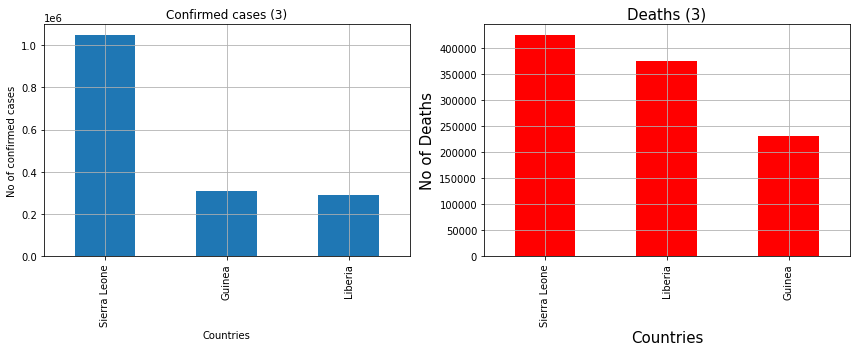

In [28]:
# Barcharts showing Countries with the highest number of confirmed cases and highest number of Deaths
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df_1.groupby('Country')['Confirmed cases'].sum().nlargest(3).plot(kind = 'bar', grid = True)
plt.title('Confirmed cases (3)')
plt.xlabel('Countries')
plt.ylabel('No of confirmed cases')


plt.subplot(1,2,2)
df_1.groupby('Country')['Deaths'].sum().nlargest(3).plot(kind = 'bar', grid = True,
                                                                       color = 'red')
plt.title('Deaths (3)', size=15)
plt.xlabel('Countries', size=15)
plt.ylabel('No of Deaths', size=15)
plt.tight_layout()
plt.show()



In [29]:
#Countries with the top 3 highest number of suspected cases
df_1.groupby('Country')['Suspected Cases'].sum().nlargest(3)

Country
Liberia         301702.0
Sierra Leone    283025.0
Guinea            5542.0
Name: Suspected Cases, dtype: float64

In [30]:
#Countries with the top 3 highest number of Probable cases
df_1.groupby('Country')['Probable cases'].sum().nlargest(3)

Country
Liberia         216041.0
Guinea           42074.5
Sierra Leone     32274.0
Name: Probable cases, dtype: float64

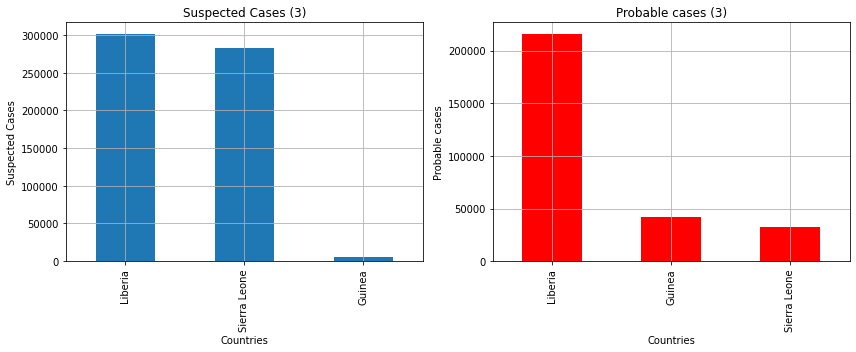

In [31]:
# Barcharts showing Countries with the highest number of Suspected cases and highest number of Probable cases

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df_1.groupby('Country')['Suspected Cases'].sum().nlargest(3).plot(kind = 'bar', grid = True)
plt.title('Suspected Cases (3)')
plt.xlabel('Countries')
plt.ylabel('Suspected Cases')

plt.subplot(1,2,2)
df_1.groupby('Country')['Probable cases'].sum().nlargest(3).plot(kind = 'bar', grid = True,
                                                                       color = 'red')
plt.title('Probable cases (3)')
plt.xlabel('Countries')
plt.ylabel('Probable cases')
plt.tight_layout()
plt.show()

In [32]:
df_1.Country.unique()

array(['Guinea', 'Liberia', 'Sierra Leone', 'Nigeria', 'Senegal', 'Mali'],
      dtype=object)

In [33]:
# Sierra Leone

df_Liberia= df_1[df_1['Country']=='Liberia']
df_Liberia= df_Liberia.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Liberia= df_Liberia.reset_index()

df_Liberia['Cases']=df_Liberia['Cases'].abs()
df_Liberia['Recovered']=df_Liberia['Recovered'].abs()
df_Liberia['Deaths']=df_Liberia['Deaths'].abs()

#--------------


fig=px.area(df_Liberia.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Liberia')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [34]:
# Sierra Leone

df_Sierra= df_1[df_1['Country']=='Sierra Leone']
df_Sierra= df_Sierra.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Sierra= df_Sierra.reset_index()

df_Sierra['Cases']=df_Sierra['Cases'].abs()
df_Sierra['Recovered']=df_Sierra['Recovered'].abs()
df_Sierra['Deaths']=df_Sierra['Deaths'].abs()

#--------------------------------------


fig=px.area(df_Sierra.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Sierra Leone')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [35]:
# Guinea

df_Guinea= df_1[df_1['Country']=='Guinea']
df_Guinea= df_Guinea.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Guinea= df_Guinea.reset_index()

df_Guinea['Cases']=df_Guinea['Cases'].abs()
df_Guinea['Recovered']=df_Guinea['Recovered'].abs()
df_Guinea['Deaths']=df_Guinea['Deaths'].abs()

#--------------


fig=px.area(df_Guinea.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Guinea')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Creating the Coropleth

In [36]:
# Creating the Coropleth

fig = go.Figure(data=go.Choropleth(
    locations = df_1['Country'],
    locationmode = 'country names',
    z = df_1['Confirmed cases'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))
fig.update_layout(
    title_text = 'Confirmed Cases',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
    )
)

In [37]:
df_1_total=df_1.groupby('Country')['Cases','Deaths'].sum()
df_1_total=df_1_total.reset_index()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [38]:
df_1_total

Category,Country,Cases,Deaths
0,Guinea,363349.5,230414.0
1,Liberia,843783.0,375444.0
2,Mali,52.0,42.0
3,Nigeria,460.0,168.0
4,Senegal,19.0,0.0
5,Sierra Leone,1367120.0,424962.0


In [39]:
fig = px.choropleth(df_1_total, locations="Country", locationmode='country names',
                    color="Cases", hover_name="Country", 
                            scope ="africa",
                    color_continuous_scale="dense",
                     labels={'Cases':'Cases'},
                     title={
                         'text': "EBOLA Total Cases",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [40]:
fig = px.choropleth(df_1_total, locations="Country", locationmode='country names',
                    color="Deaths", hover_name="Country", 
                            scope ="africa",
                    color_continuous_scale="dense",
                     labels={'Deaths':'Deaths'},
                     title={
                         'text': "EBOLA Total Deaths",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

# Now Modeling Ebola Virus Disease Cases using ARIMA Model

In [18]:
df.head()

,Country,Localite,Category,Value,Date
0,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Cases,86.0,2014-03-24
1,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Deaths,59.0,2014-03-24
2,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86.0,2014-03-25
3,Guinea,"( Guekedou, Macenta and Kissidougou",Deaths,60.0,2014-03-25
4,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86.0,2014-03-26


In [19]:
list(df.Category.unique())

['Cases',
 'Deaths',
 'Suspected Cases',
 'Confirmed cases',
 'Probable cases',
 'New Cases']

In [58]:
# Here we are selecting 'Guinea' country for modeling EVD especially Confirmed Cases to Farcast future cases.

df_Guinea_cases=df[df.Country=='Guinea'][df.Localite=='National'][df.Category=='Confirmed cases']
df_Guinea_cases=df_Guinea_cases[['Value','Date']].set_index('Date').sort_values(by='Date', ascending=True)
print(df_Guinea_cases.head())

# Here we are selecting 'Guinea' country for modeling EVD especially Confirmed Cases to Farcast future cases.

df_Guinea_deaths=df[df.Country=='Guinea'][df.Localite=='National'][df.Category=='Deaths']
df_Guinea_deaths=df_Guinea_deaths[['Value','Date']].set_index('Date').sort_values(by='Date', ascending=True)
print(df_Guinea_deaths.head())


            Value
Date             
2014-03-31   24.0
2014-04-01   35.0
2014-04-04   54.0
2014-04-11   71.0
2014-04-16  101.0
            Value
Date             
2014-03-31   80.0
2014-04-01   83.0
2014-04-04   86.0
2014-04-07   95.0
2014-04-10  101.0


C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



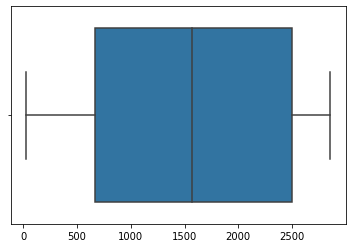

In [21]:
# Plotting boxplot to see any outlier in the Dataset
sns.boxplot(df_Guinea_cases)


In [22]:
indexDataset= df_Guinea_cases.copy()

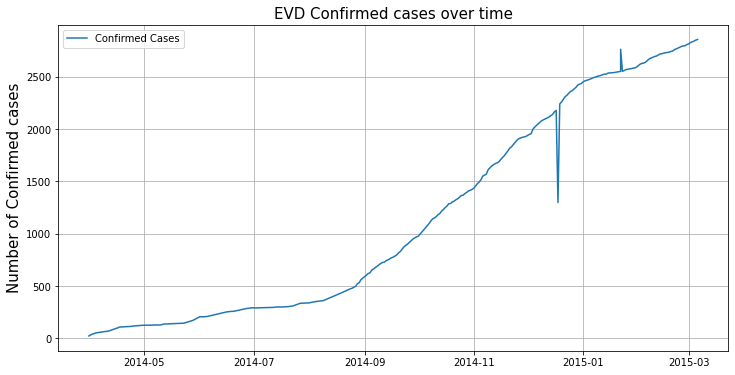

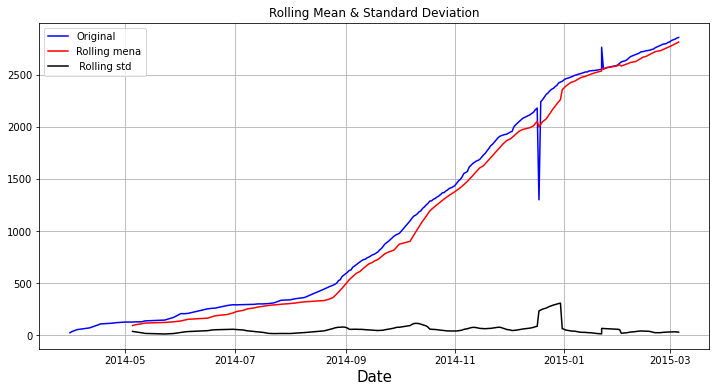

In [23]:
#plot graph.
plt.figure(figsize=(12,6))

plt.ylabel('Number of Confirmed cases',fontsize=15)
plt.title('EVD Confirmed cases over time',fontsize=15)
plt.plot(indexDataset, label='Confirmed Cases')
plt.legend()
plt.grid()


# Determining rolling statistics
rolmean = indexDataset.rolling(window=12).mean()
rolstd = indexDataset.rolling(window=12).std()
# print(rolmean,rolstd)

# Plot rolling statistics

plt.figure( figsize=(12,6))
orig= plt.plot(indexDataset, color='blue',label='Original')
mean= plt.plot(rolmean, color='red',label='Rolling mena')
std= plt.plot(rolstd, color='black', label=' Rolling std')
plt.legend(loc='best')
plt.xlabel('Date',fontsize=15)
plt.grid()
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Checking the stationarity using adfuller test

In [24]:
# Perform Dickey Fuller test : method-1
from statsmodels.tsa.stattools import adfuller
print('Result of Dickey-Fuller Test :')
dftest= adfuller(indexDataset['Value'],autolag='AIC')

dfoutput= pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]= value

print(dfoutput)    


#---------------------------------------------------------------
# # Perform Dickey Fuller test : method-2
# from statsmodels.tsa.stattools import adfuller

# def ad_test(dataset):
#     dftest=adfuller(dataset, autolag='AIC')
#     print("1.ADF :", dftest[0])
#     print("2.P-Value :", dftest[1])
#     print("3.Num of Lags :", dftest[2])
#     print("4.Number of observations used for ADF Regressiomn and Critical value calculation :", dftest[3])
#     print("5. Critical Values :")
#     for key, val in dftest[4].items():
#         print("\t", key, ":", val)   

# ad_test(indexDataset['Value'])
    

Result of Dickey-Fuller Test :
Test Statistics                 -0.973821
p-value                          0.762692
#Lags Used                       5.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


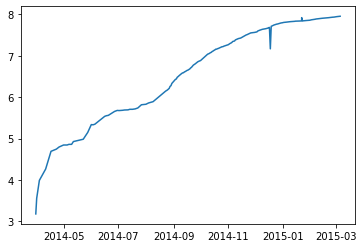

In [25]:
# Now taking log

df_log= np.log(indexDataset)
plt.plot(df_log)

In [26]:
# Let's create a function which determine wheather a the given time series is stationary

def check_stationarity(dataset):
    
    # rolling statistics
    rolling_mean = dataset.rolling(window=2).mean()
    rollingh_std = dataset.rolling(window=2).std()
    
    # rolling plot
    original =plt.plot(dataset, color='blue', label='Original')
    mean= plt.plot( rolling_mean, color='red', label='Rolling Mean')
    std= plt.plot(rollingh_std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Deviation')
    plt.grid()
    plt.show(block=False)
    
    # Dickey-Fuller test:
    result= adfuller( dataset)
    print('ADF Statistics:{}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('# Lag Used: {}'.format(result[2]))
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t{}:{}'.format(key, value))
        
    if result[1]<0.5:
            print('H0 is rejected hence data is stationary')
    else:
            print('Ho is accected hence data is Non-stationary')
                

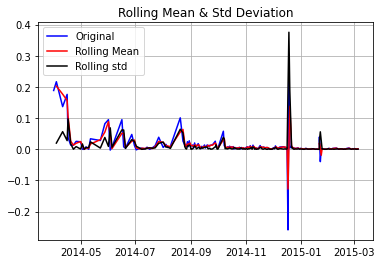

ADF Statistics:-3.2164691690228784
p-value: 0.019050952887644586
# Lag Used: 15
Critical Values:
	1%:-3.4646940755442612
	5%:-2.8766348847254934
	10%:-2.5748163958763994
H0 is rejected hence data is stationary


In [27]:
rolling_mean=df_log.rolling(window=2).mean()
df_log_minus_mean = df_log-rolling_mean
df_log_minus_mean.dropna(inplace=True)

check_stationarity(df_log_minus_mean)

In [28]:
indexDataset['First Diff']=indexDataset['Value'].diff(1)

indexDataset['Seasonal Diff']=indexDataset['Value'].diff(12)
indexDataset


,Value,First Diff,Seasonal Diff
Date,,,
2014-03-31,24.0,NaN,NaN
2014-04-01,35.0,11.0,NaN
2014-04-04,54.0,19.0,NaN
2014-04-11,71.0,17.0,NaN
2014-04-16,101.0,30.0,NaN
...,...,...,...
2015-03-02,2827.0,14.0,98.0
2015-03-03,2833.0,6.0,101.0
2015-03-04,2840.0,7.0,106.0


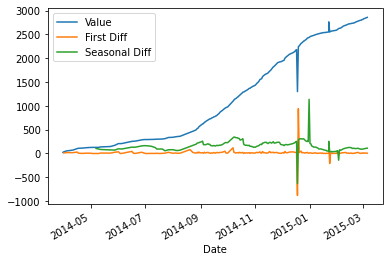

In [29]:
indexDataset.plot()

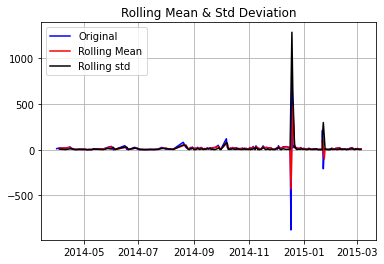

ADF Statistics:-9.78005826363854
p-value: 6.770939121854098e-17
# Lag Used: 4
Critical Values:
	1%:-3.462818103072159
	5%:-2.8758145932936805
	10%:-2.574378674548251
H0 is rejected hence data is stationary


In [30]:
# Now checking again stationarity

check_stationarity(indexDataset['First Diff'].dropna())

### Plotting ACF and PACF graph in order to determine p,d,q(AR,I,MA)¶

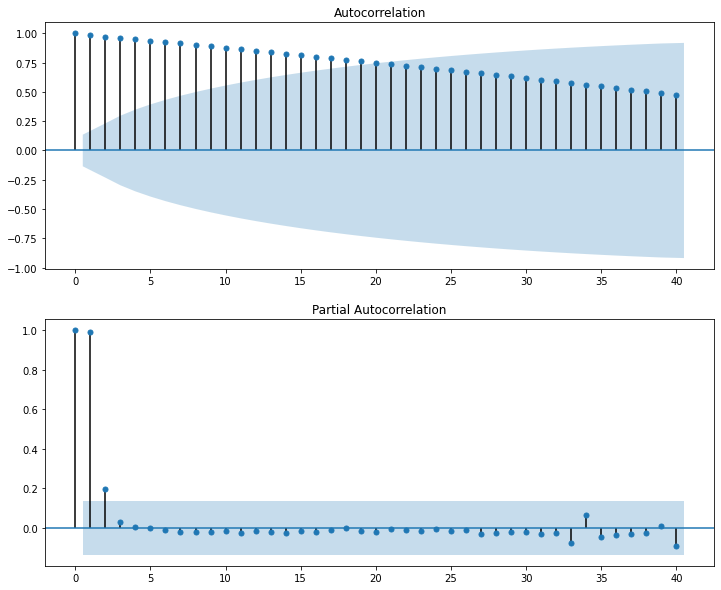

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax= plt.subplots(2, figsize=(12,10))
ax[0]=plot_acf(indexDataset['Value'],ax=ax[0],lags=40)
ax[1]=plot_pacf(indexDataset['Value'],ax=ax[1],lags=40)

## Mannualy determine optimal p,d,q values

In [56]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


# minimum AIC values among all AIC is believed to be best ARIMA model
# Best way to choose the min AIC  values by running loop for Non-Seasonal dataset

import itertools
import warnings
warnings.filterwarnings('ignore')

p=d=q=range(0,3)

pdq=list(itertools.product(p,d,q))

pred_list=list()
aic_list=list()
order_list=list()

for pm in pdq:
    
    try:
        model= ARIMA(indexDataset['Value'],order=pm)
        model_fit= model.fit()
        pred_y= model_fit.forecast()[0]
        AIC= model_fit.aic
        order_list.append(pm)
        pred_list.append(pred_y)
        aic_list.append(AIC)
        print("ARIMA %s AIC = %.2f" %(pm, AIC))
        
    except:
        continue 
        
df_aic= pd.DataFrame(list(zip(order_list,pred_list,aic_list)),columns=['Order','Prediction','AIC'])        



ARIMA (0, 0, 0) AIC = 3468.72
ARIMA (0, 0, 1) AIC = 3223.33
ARIMA (0, 0, 2) AIC = 3051.73
ARIMA (0, 1, 0) AIC = 2488.86
ARIMA (0, 1, 1) AIC = 2400.79
ARIMA (0, 1, 2) AIC = 2402.59
ARIMA (0, 2, 0) AIC = 2704.31
ARIMA (0, 2, 1) AIC = 2485.25
ARIMA (0, 2, 2) AIC = 2397.68
ARIMA (1, 0, 0) AIC = 2512.28
ARIMA (1, 0, 1) AIC = 2458.07
ARIMA (1, 0, 2) AIC = 2457.58
ARIMA (1, 1, 0) AIC = 2435.24
ARIMA (1, 1, 1) AIC = 2402.61
ARIMA (1, 1, 2) AIC = 2402.86
ARIMA (1, 2, 0) AIC = 2584.05
ARIMA (2, 0, 0) AIC = 2466.71
ARIMA (2, 0, 1) AIC = 2458.15
ARIMA (2, 0, 2) AIC = 2469.42
ARIMA (2, 1, 0) AIC = 2419.25
ARIMA (2, 1, 1) AIC = 2404.52
ARIMA (2, 1, 2) AIC = 2404.85
ARIMA (2, 2, 0) AIC = 2530.88


In [92]:
df_aic.sort_values(by='AIC',ascending=True)[5:10]

,Order,Prediction,AIC
20,"(2, 1, 1)",[2883.4485747534563],2404.521278
21,"(2, 1, 2)",[2877.190385795078],2404.854232
19,"(2, 1, 0)",[2875.2967867040993],2419.246723
12,"(1, 1, 0)",[2873.2138056506515],2435.237437
11,"(1, 0, 2)",[2848.262310573942],2457.583919


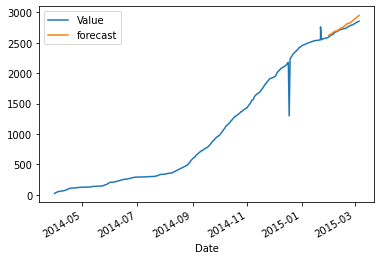

In [133]:
###For non-seasonal data

from statsmodels.tsa.arima_model import ARIMA

model= ARIMA(indexDataset['Value'], order=(2,1,2))
model_fit= model.fit()

# # model_fit.summary()

indexDataset['forecast']= model_fit.predict(start=180, end=209,typ='levels' ,dynamic=True)
indexDataset[['Value','forecast']].plot()

In [117]:
import pandas as pd


In [124]:
from pandas.tseries.offsets import DateOffset

future_dates= [indexDataset.index[-1]+DateOffset(months=x) for x in range(0,8)]   # we are adding next 2 year more
future_dates_df= pd.DataFrame(index=future_dates[1:],columns=indexDataset.columns)
future_df= pd.concat([indexDataset,future_dates_df])


In [125]:
future_df

,Value,First Diff,Seasonal Diff,forecast
2014-03-31,24.0,NaN,NaN,NaN
2014-04-01,35.0,11.0,NaN,NaN
2014-04-04,54.0,19.0,NaN,NaN
2014-04-11,71.0,17.0,NaN,NaN
2014-04-16,101.0,30.0,NaN,NaN
...,...,...,...,...
2015-06-06,NaN,NaN,NaN,NaN
2015-07-06,NaN,NaN,NaN,NaN
2015-08-06,NaN,NaN,NaN,NaN
2015-09-06,NaN,NaN,NaN,NaN


### Now find the best fitted SARIMAX model to the given dataset¶

In [32]:
#---------------100% working---------------------------------------------------------------------

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

p=d=q=range(0,3)

pdq=list(itertools.product(p,d,q))
seasonal_pdq =[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]


metric_aic_dic=dict()   # Here we are storing our AICs result  one by one

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        
        try:
            model= sm.tsa.statespace.SARIMAX(indexDataset['Value'], order=pm, seasonal_order=pm_seasonal)
            model_aic= model.fit()
            print('ARIMA {} x {}x12 - AIC :{}'.format(pm, pm_seasonal, model_aic.aic))
            metric_aic_dic.update({(pm,pm_seasonal):model_aic.aic})
        except: 
            continue  
            
### Conveting AICs dict values into datafram and then sorting its values, in order to find minimum AIC
aic_df=pd.DataFrame({'(p,d,q)x(p,d,q,12)':metric_aic_dic.keys(), 'AIC':metric_aic_dic.values()})            

ARIMA (0, 0, 0) x (0, 0, 0, 12)x12 - AIC :3745.649852742931
ARIMA (0, 0, 0) x (0, 0, 1, 12)x12 - AIC :3508.9151833712513
ARIMA (0, 0, 0) x (0, 0, 2, 12)x12 - AIC :3381.1631584029274
ARIMA (0, 0, 0) x (0, 1, 0, 12)x12 - AIC :2668.4366002412985
ARIMA (0, 0, 0) x (0, 1, 1, 12)x12 - AIC :2629.2008463290686
ARIMA (0, 0, 0) x (0, 1, 2, 12)x12 - AIC :2599.7396776545042
ARIMA (0, 0, 0) x (0, 2, 0, 12)x12 - AIC :2477.0295597490076
ARIMA (0, 0, 0) x (0, 2, 1, 12)x12 - AIC :2354.897609325809
ARIMA (0, 0, 0) x (0, 2, 2, 12)x12 - AIC :2354.314429880843
ARIMA (0, 0, 0) x (1, 0, 0, 12)x12 - AIC :2886.171384093899
ARIMA (0, 0, 0) x (1, 0, 1, 12)x12 - AIC :2846.9122405269627
ARIMA (0, 0, 0) x (1, 0, 2, 12)x12 - AIC :2817.6899078476226
ARIMA (0, 0, 0) x (1, 1, 0, 12)x12 - AIC :2589.307203690234
ARIMA (0, 0, 0) x (1, 1, 1, 12)x12 - AIC :2513.27583768982
ARIMA (0, 0, 0) x (1, 1, 2, 12)x12 - AIC :2507.6101908876594
ARIMA (0, 0, 0) x (1, 2, 0, 12)x12 - AIC :2398.7278036425278
ARIMA (0, 0, 0) x (1, 2, 1, 12)

ARIMA (0, 1, 2) x (0, 1, 1, 12)x12 - AIC :2299.7400883191867
ARIMA (0, 1, 2) x (0, 1, 2, 12)x12 - AIC :2301.5196794303856
ARIMA (0, 1, 2) x (0, 2, 0, 12)x12 - AIC :2468.604977048924
ARIMA (0, 1, 2) x (0, 2, 1, 12)x12 - AIC :2302.6199359008388
ARIMA (0, 1, 2) x (0, 2, 2, 12)x12 - AIC :2242.311152352992
ARIMA (0, 1, 2) x (1, 0, 0, 12)x12 - AIC :2435.0111876816536
ARIMA (0, 1, 2) x (1, 0, 1, 12)x12 - AIC :2426.4938077089328
ARIMA (0, 1, 2) x (1, 0, 2, 12)x12 - AIC :2428.3506983654306
ARIMA (0, 1, 2) x (1, 1, 0, 12)x12 - AIC :2353.3388666548135
ARIMA (0, 1, 2) x (1, 1, 1, 12)x12 - AIC :2301.518540570748
ARIMA (0, 1, 2) x (1, 1, 2, 12)x12 - AIC :2303.520275091256
ARIMA (0, 1, 2) x (1, 2, 0, 12)x12 - AIC :2371.319147264021
ARIMA (0, 1, 2) x (1, 2, 1, 12)x12 - AIC :2265.709771017645
ARIMA (0, 1, 2) x (1, 2, 2, 12)x12 - AIC :2244.1569579825814
ARIMA (0, 1, 2) x (2, 0, 0, 12)x12 - AIC :2434.9753664398027
ARIMA (0, 1, 2) x (2, 0, 1, 12)x12 - AIC :2428.345021903482
ARIMA (0, 1, 2) x (2, 0, 2, 12)

ARIMA (1, 0, 1) x (0, 1, 2, 12)x12 - AIC :2314.5279477840495
ARIMA (1, 0, 1) x (0, 2, 0, 12)x12 - AIC :2466.966508065182
ARIMA (1, 0, 1) x (0, 2, 1, 12)x12 - AIC :2310.8135705873774
ARIMA (1, 0, 1) x (0, 2, 2, 12)x12 - AIC :2248.65090964519
ARIMA (1, 0, 1) x (1, 0, 0, 12)x12 - AIC :2455.050262676531
ARIMA (1, 0, 1) x (1, 0, 1, 12)x12 - AIC :2447.225622025742
ARIMA (1, 0, 1) x (1, 0, 2, 12)x12 - AIC :2449.224986147936
ARIMA (1, 0, 1) x (1, 1, 0, 12)x12 - AIC :2365.20126940882
ARIMA (1, 0, 1) x (1, 1, 1, 12)x12 - AIC :2314.6243841173637
ARIMA (1, 0, 1) x (1, 1, 2, 12)x12 - AIC :2316.8246171215505
ARIMA (1, 0, 1) x (1, 2, 0, 12)x12 - AIC :2373.7703197206847
ARIMA (1, 0, 1) x (1, 2, 1, 12)x12 - AIC :2273.23199553047
ARIMA (1, 0, 1) x (1, 2, 2, 12)x12 - AIC :2250.335460778588
ARIMA (1, 0, 1) x (2, 0, 0, 12)x12 - AIC :2454.578210748192
ARIMA (1, 0, 1) x (2, 0, 1, 12)x12 - AIC :2449.3986741737936
ARIMA (1, 0, 1) x (2, 0, 2, 12)x12 - AIC :2451.218270690432
ARIMA (1, 0, 1) x (2, 1, 0, 12)x12 - 

ARIMA (1, 2, 0) x (0, 2, 1, 12)x12 - AIC :2466.822464667246
ARIMA (1, 2, 0) x (0, 2, 2, 12)x12 - AIC :2401.335525208836
ARIMA (1, 2, 0) x (1, 0, 0, 12)x12 - AIC :2584.0138331248545
ARIMA (1, 2, 0) x (1, 0, 1, 12)x12 - AIC :2586.016270796649
ARIMA (1, 2, 0) x (1, 0, 2, 12)x12 - AIC :2588.0162671529806
ARIMA (1, 2, 0) x (1, 1, 0, 12)x12 - AIC :2528.62982110129
ARIMA (1, 2, 0) x (1, 1, 1, 12)x12 - AIC :2472.4615197170324
ARIMA (1, 2, 0) x (1, 1, 2, 12)x12 - AIC :2474.4628404048103
ARIMA (1, 2, 0) x (1, 2, 0, 12)x12 - AIC :2531.814396906054
ARIMA (1, 2, 0) x (1, 2, 1, 12)x12 - AIC :2428.3391005411363
ARIMA (1, 2, 0) x (1, 2, 2, 12)x12 - AIC :2402.558652077245
ARIMA (1, 2, 0) x (2, 0, 0, 12)x12 - AIC :2586.0162540823076
ARIMA (1, 2, 0) x (2, 0, 1, 12)x12 - AIC :2588.0162552392717
ARIMA (1, 2, 0) x (2, 0, 2, 12)x12 - AIC :2589.677296819658
ARIMA (1, 2, 0) x (2, 1, 0, 12)x12 - AIC :2513.8094685616115
ARIMA (1, 2, 0) x (2, 1, 1, 12)x12 - AIC :2474.450631250088
ARIMA (1, 2, 0) x (2, 1, 2, 12)x1

ARIMA (2, 0, 2) x (0, 2, 2, 12)x12 - AIC :2263.4780387987057
ARIMA (2, 0, 2) x (1, 0, 0, 12)x12 - AIC :2459.0373379624552
ARIMA (2, 0, 2) x (1, 0, 1, 12)x12 - AIC :2450.88708054404
ARIMA (2, 0, 2) x (1, 0, 2, 12)x12 - AIC :2453.0089285807267
ARIMA (2, 0, 2) x (1, 1, 0, 12)x12 - AIC :2365.590710723328
ARIMA (2, 0, 2) x (1, 1, 1, 12)x12 - AIC :2318.8219906065906
ARIMA (2, 0, 2) x (1, 1, 2, 12)x12 - AIC :2320.5545306345684
ARIMA (2, 0, 2) x (1, 2, 0, 12)x12 - AIC :2371.804825595591
ARIMA (2, 0, 2) x (1, 2, 1, 12)x12 - AIC :2277.558326941152
ARIMA (2, 0, 2) x (1, 2, 2, 12)x12 - AIC :2254.3259482359554
ARIMA (2, 0, 2) x (2, 0, 0, 12)x12 - AIC :2458.5483273967116
ARIMA (2, 0, 2) x (2, 0, 1, 12)x12 - AIC :2453.0101568449836
ARIMA (2, 0, 2) x (2, 0, 2, 12)x12 - AIC :2454.9271548478287
ARIMA (2, 0, 2) x (2, 1, 0, 12)x12 - AIC :2348.3425596671914
ARIMA (2, 0, 2) x (2, 1, 1, 12)x12 - AIC :2320.5155457824067
ARIMA (2, 0, 2) x (2, 1, 2, 12)x12 - AIC :2324.139252978058
ARIMA (2, 0, 2) x (2, 2, 0, 12

ARIMA (2, 2, 1) x (1, 0, 0, 12)x12 - AIC :2417.145889102853
ARIMA (2, 2, 1) x (1, 0, 1, 12)x12 - AIC :2418.9114750481904
ARIMA (2, 2, 1) x (1, 0, 2, 12)x12 - AIC :2420.911246298447
ARIMA (2, 2, 1) x (1, 1, 0, 12)x12 - AIC :2371.3006649470335
ARIMA (2, 2, 1) x (1, 1, 1, 12)x12 - AIC :2316.680539649915
ARIMA (2, 2, 1) x (1, 1, 2, 12)x12 - AIC :2318.589549464199
ARIMA (2, 2, 1) x (1, 2, 0, 12)x12 - AIC :2389.7811418965507
ARIMA (2, 2, 1) x (1, 2, 1, 12)x12 - AIC :2284.0968134383493
ARIMA (2, 2, 1) x (1, 2, 2, 12)x12 - AIC :2279.5919295651784
ARIMA (2, 2, 1) x (2, 0, 0, 12)x12 - AIC :2419.1413951476097
ARIMA (2, 2, 1) x (2, 0, 1, 12)x12 - AIC :2420.9112525607297
ARIMA (2, 2, 1) x (2, 0, 2, 12)x12 - AIC :2422.8813066342636
ARIMA (2, 2, 1) x (2, 1, 0, 12)x12 - AIC :2349.7879315378605
ARIMA (2, 2, 1) x (2, 1, 1, 12)x12 - AIC :2318.6382614632985
ARIMA (2, 2, 1) x (2, 1, 2, 12)x12 - AIC :2320.6765758868387
ARIMA (2, 2, 1) x (2, 2, 0, 12)x12 - AIC :2340.296676499993
ARIMA (2, 2, 1) x (2, 2, 1, 1

In [61]:
### Conveting AICs dict values into datafram and then sorting its values, in order to find minimum AIC
aic_df=pd.DataFrame({'(p,d,q)x(p,d,q,12)':metric_aic_dic.keys(), 'AIC':metric_aic_dic.values()})     
aic_df.sort_values(by='AIC')[:6]

,"(p,d,q)x(p,d,q,12)",AIC
221,"((0, 2, 2), (0, 2, 2, 12))",2237.904737
230,"((0, 2, 2), (1, 2, 2, 12))",2239.683255
464,"((1, 2, 2), (0, 2, 2, 12))",2239.841426
113,"((0, 1, 1), (0, 2, 2, 12))",2240.562098
140,"((0, 1, 2), (0, 2, 2, 12))",2242.311152
122,"((0, 1, 1), (1, 2, 2, 12))",2242.499946


In [87]:
# After running loop we get (1,2,2)x(0,2,2,12) for optimum forcasting
import statsmodels.api as sm

model1= sm.tsa.statespace.SARIMAX(indexDataset['Value'],order=(0,1,2)\
                                 , seasonal_order=(0,2,2,12))
results1= model1.fit()



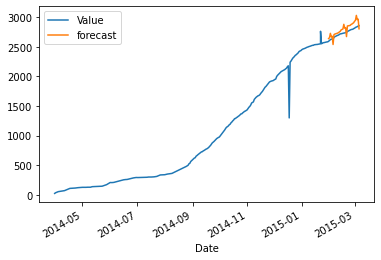

In [88]:
# Forcasting Mannual Model


indexDataset['forecast']= results1.predict(start=180,end=209, dynamic=True)
indexDataset[['Value','forecast']].plot()

In [89]:
# Now we are gonna predict future value by adding some new date

from pandas.tseries.offsets import DateOffset

future_dates= [indexDataset.index[-1]+DateOffset(months=x) for x in range(0,8)]

future_dates_df= pd.DataFrame(index=future_dates[1:],columns=indexDataset.columns )

future_df= pd.concat([indexDataset, future_dates_df])

In [90]:
len(future_df)

217

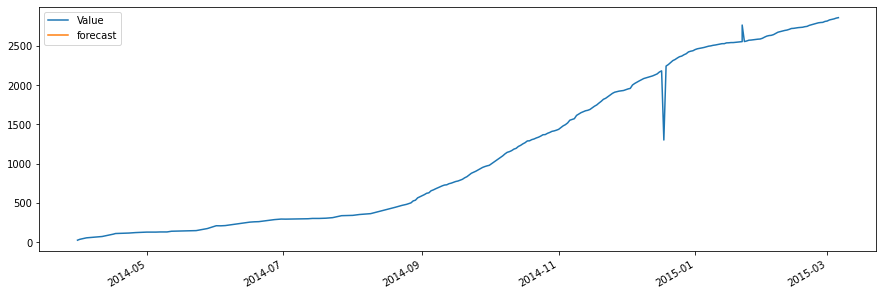

In [91]:
future_df['forecast']=results1.predict(start=180, end=215, dynamic=True)
future_df[['Value','forecast']].plot(figsize=(15,5))

In [58]:
# Now Modeling


print(indexDataset.shape)
train=indexDataset.iloc[:-60]
test=indexDataset.iloc[-60:]

print(train.shape, test.shape)


(210, 1)
(150, 1) (60, 1)


In [59]:
# Train the Model

model= ARIMA( train['Value'], order=(0,1,1))
model_fit= model.fit()
model_fit.summary()

# Now forcasting
model_forcast= model_fit.forecast(steps=60)[0]


In [60]:
# Now Ckecking the accuracy of ARIMA model
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse= sqrt(mean_squared_error(model_forcast, test['Value']))
print(rmse)

336.4044866655962


In [61]:
# Now Converting forcatsted values into dataframe
model_forcast=pd.DataFrame(model_forcast, index=test.index)

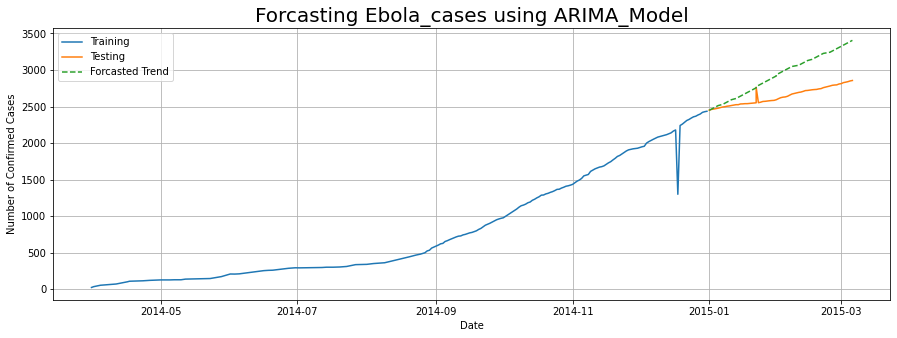

In [62]:
# Plotting the graph between traing, testing and Forcasted values

plt.figure(figsize=(15,5))
plt.plot(train, label='Training')

plt.plot(test, label='Testing')
plt.plot(model_forcast, label='Forcasted Trend',linestyle='dashed')
plt.title('Forcasting Ebola_cases using ARIMA_Model',fontdict={'fontsize':20,'fontweight' :1})
plt.xlabel('Date',fontdict={'fontsize':10,'fontweight' :1})
plt.ylabel('Number of Confirmed Cases',fontdict={'fontsize':10,'fontweight' :1})

plt.legend()
plt.grid()



# Now Applying SVR Machine Learning Model to predict the Ebola Virus

In [22]:
# Importing SVR libraries

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [89]:
len(df_Guinea_cases)

210

In [91]:
df_Guinea_cases.insert(1,'Days3',range(1,211))

In [103]:
df_Guinea_cases['Days']=df_Guinea_cases['Days'].dt.day

AttributeError: Can only use .dt accessor with datetimelike values

In [99]:
df_Guinea_cases



,Value,Days3,Days2,Days1,Days
Date,,,,,
2014-03-31,24.0,1,0,0,31
2014-04-01,35.0,2,1,1,1
2014-04-04,54.0,3,2,2,4
2014-04-11,71.0,4,3,3,11
2014-04-16,101.0,5,4,4,16
...,...,...,...,...,...
2015-03-02,2827.0,206,205,205,2
2015-03-03,2833.0,207,206,206,3
2015-03-04,2840.0,208,207,207,4


In [37]:
X= df_Guinea_cases1['Value'].values
X= np.array(X).reshape(-1,1)

In [62]:
y=df_Guinea_cases.index
y= np.array(y).reshape(-1,1)

# Feature Scaling

In [63]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y=sc_y.fit_transform(y)



In [66]:
# Training the SVR model on the whole dataset

from sklearn.svm import SVR

# Model1
regressor1= SVR(kernel='rbf')
regressor1.fit(X,y)

# Model2
regressor2= SVR(kernel='poly',C=1e3, degree=3)
regressor2.fit(X,y)


C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR(C=1000.0, kernel='poly')

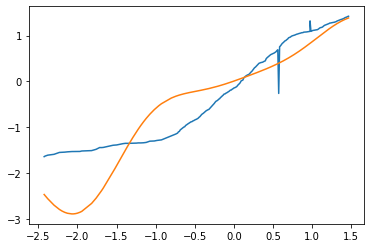

In [67]:
plt.plot(y,X)
plt.plot(y,regressor1.predict(y))


In [72]:
# Checking Mean_absulut_error and Mean_squared_error
# mean_squared_error(test_value, predicted_value)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from  sklearn.metrics import accuracy_score

MAE=mean_absolute_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))
MSE=mean_squared_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))

print(" MAE :", MAE)
print("MSE :", MSE)
print('RMSE :', np.sqrt(MSE))

 MAE : 46.840222426624116
MSE : 6273.845861974491
RMSE : 79.20761239915322


# Plotting SVR Machine Learning Model

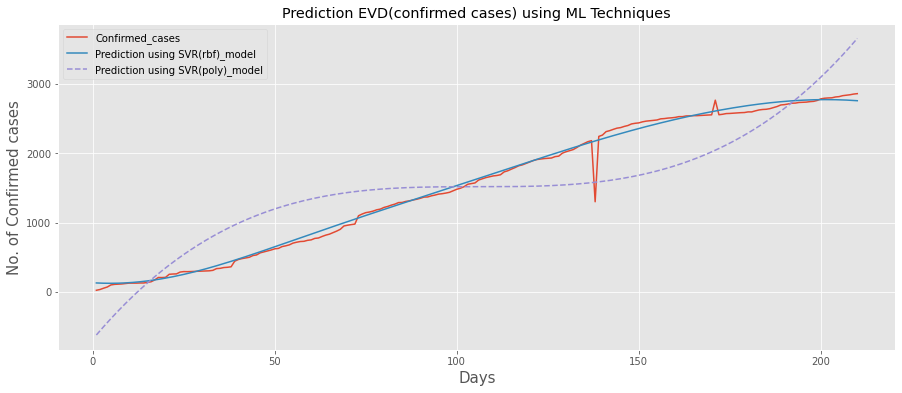

In [73]:
plt.style.use('ggplot')
plt.figure(figsize=(15,6))
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(y), label='Confirmed_cases')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor1.predict(X)), label='Prediction using SVR(rbf)_model' )
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor2.predict(X)), linestyle='dashed', label='Prediction using SVR(poly)_model' )

plt.title('Prediction EVD(confirmed cases) using ML Techniques')
plt.xlabel('Days', size=15)
plt.ylabel('No. of Confirmed cases', size=15)

plt.legend()

# Now Prediction for Death over time using SVR ML model

In [74]:
df_Guinea_deaths=df_Guinea_deaths.reset_index()

df_Guinea_deaths['No_of_Days']=df_Guinea_deaths.index.values+1


#-----------------------------------------
Days=[]
Deaths =[]

# Now Creating independent Dataset for Days

for day in df_Guinea_deaths.No_of_Days:
    Days.append(day)
    
# Now Creating independent Dataset for Confirmed Cases

for death in df_Guinea_deaths.Value:
    Deaths.append(death)
#--------------------------------------------------------    
# Reshaping Days & Confirmed cases
Days= np.array(Days).reshape(-1,1)
Deaths=np.array(Deaths).reshape(-1,1)

#-----------------------------
X= Days
y=Deaths

#-----------------------------------------------------------------

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
#--------------------------------------------------
# Training the SVR model on the whole dataset

from sklearn.svm import SVR

# Model1
regressor1= SVR(kernel='rbf')
regressor1.fit(X,y)

# Model2
regressor2= SVR(kernel='poly')
regressor2.fit(X,y)


SVR(kernel='poly')

In [75]:
# Checking Mean_absulut_error and Mean_squared_error
# mean_squared_error(test_value, predicted_value)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from  sklearn.metrics import accuracy_score

MAE=mean_absolute_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))
MSE=mean_squared_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))

print(" MAE :", MAE)
print("MSE :", MSE)
print('RMSE :', np.sqrt(MSE))




 MAE : 28.122669740996837
MSE : 1312.348868555976
RMSE : 36.226355993336895


# Visualization of Death predictions in Guinea using SVR ML Model

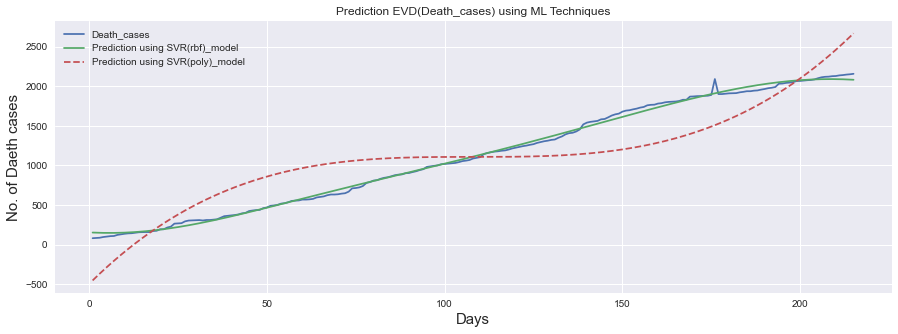

In [76]:
#-----------------------------------------------------
#------- now plotting -----------------------------------
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(y), label='Death_cases')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor1.predict(X)), label='Prediction using SVR(rbf)_model' )
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor2.predict(X)), linestyle='dashed', label='Prediction using SVR(poly)_model' )

plt.title('Prediction EVD(Death_cases) using ML Techniques')
plt.xlabel('Days', size=15)
plt.ylabel('No. of Daeth cases', size=15)

plt.legend()

#--------------------------------------------------